In [14]:
import pandas as pd
import numpy as np

from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [15]:
# links used

# https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb
# https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
df = pd.read_csv('project_RM.csv')
df['<DATE>'] = pd.to_datetime(df['<DATE>'], format="%d/%m/%y")
df.columns = ['TICKER', 'DATE', 'CLOSE']

In [18]:
df

,TICKER,DATE,CLOSE
0,AFKS,2008-01-10,41.55
1,AFKS,2008-01-11,42.34
2,AFKS,2008-01-12,46.20
3,AFKS,2008-01-15,44.75
4,AFKS,2008-01-16,44.60
...,...,...,...
102488,YDEX,2024-12-26,3790.00
102489,YDEX,2024-12-27,3785.00
102490,YDEX,2024-12-28,3848.00
102491,YDEX,2024-12-29,3928.50


1. Историческое окно:
Скользящее окно длительностью 1 год (252 торговых дня)
Обоснование:

Баланс стабильности и актуальности: Годовой период охватывает полный рыночный цикл (включая сезонные эффекты и макроэкономические события), что снижает шум краткосрочных колебаний, но при этом остается достаточно чувствительным к изменениям последнего года.
Минимизация look-ahead bias: Скользящее окно гарантирует, что при расчете ковариаций используются только данные, доступные на момент принятия решения.
Сравнительная стабильность: Годовые окна реже страдают от проблемы "пустых окон" по сравнению с недельными/месячными интервалами, особенно для ликвидных акций.


2. Схема взвешивания:
Экспоненциальное забывание с λ = 0.94
Обоснование:

Акцент на текущих рыночных условиях: Экспоненциальные веса позволяют "забывать" старые данные, что критично в условиях:
Структурных сдвигов (например, изменения монетарной политики)
Кризисных событий (COVID-19, геополитические шоки)
Быстрого роста/падения секторов (технологический бум 2020-2021)
Гибкая адаптация: Формула весов w_i = (1-λ)*λ^(t-i) с λ=0.94 дает полупериод забывания ~11 дней, что оптимально для баланса между реактивностью и устойчивостью.
Эмпирическая проверка: Значение λ=0.94 широко используется в риск-менеджменте (например, в RiskMetrics JP Morgan) как компромисс между устойчивостью и чувствительностью.


Совместное применение (годовое окно + экспоненциальные веса):
Преимущества для построения эффективной границы:

Учет нестационарности: Комбинация позволяет:
Сохранять долгосрочные корреляции через размер окна
Динамически адаптироваться к изменениям волатильности через веса
Снижение риска переобучения:
Экспоненциальное сглаживание подавляет шум краткосрочных выбросов, делая ковариационные оценки более устойчивыми.
Реалистичность для ребалансировок:
Большинство институциональных инвесторов проводят ребалансировку портфеля с периодичностью от квартала до года — выбранные параметры соответствуют этому горизонту.


Альтернативы и почему они хуже:

Расширяющееся окно: Накопление исторических данных приводит к "размыванию" актуальных корреляций, особенно в периоды кризисов.
Короткие окна (месяц/неделя): Высокая волатильность оценок ковариаций → нестабильная эффективная граница.
Равные веса: Игнорирует изменение волатильности во времени → завышенная роль устаревших данных.


In [24]:
from tqdm import tqdm

# Преобразование в широкий формат
pivot_df = df.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index().asfreq('B').ffill()

# Расчет логарифмических доходностей
returns = np.log(pivot_df / pivot_df.shift(1))

# Параметры для скользящих и расширяющихся окон
window_params = {
    'rolling': {
        'year': {'size': 252, 'min_obs': 20},
        'quarter': {'size': 63, 'min_obs': 15},
        'month': {'size': 21, 'min_obs': 10},
        'week': {'size': 5, 'min_obs': 3},
        'day': {'size': 1, 'min_obs': 2}
    },
    'expanding': {
        'year': {'step': 252, 'min_obs': 20},
        'quarter': {'step': 63, 'min_obs': 15},
        'month': {'step': 21, 'min_obs': 10},
        'week': {'step': 5, 'min_obs': 3},
        'day': {'step': 1, 'min_obs': 2}
    }
}

lambda_ = 0.94
TICKERS = returns.columns.tolist()
results = {}

# Функция для экспоненциальных весов
# Исправленная функция весов
def exponential_weights(window_size, lambda_):
    weights = np.array([lambda_ ** i for i in range(window_size)][::-1])
    return weights / weights.sum()

# Улучшенная функция ковариации
def nan_aware_covariance(data, weights):
    weighted_sum = np.zeros((data.shape[1], data.shape[1]))
    sum_weights = np.zeros((data.shape[1], data.shape[1]))

    for i in range(data.shape[0]):
        row = data[i]
        valid = ~np.isnan(row)
        if not valid.any():
            continue

        centered = row - np.nanmean(row)
        centered[~valid] = 0
        w = weights[i]

        outer = np.outer(centered, centered)
        valid_matrix = np.outer(valid, valid)

        weighted_sum += w * outer * valid_matrix
        sum_weights += w * valid_matrix

    return np.divide(weighted_sum, sum_weights, where=sum_weights!=0)

# Обработка скользящих окон
for win_name, params in window_params['rolling'].items():
    win_size = params['size']
    min_obs = params['min_obs']

    rolling_results = {'simple': {}, 'exp': {}}
    valid_dates = 0

    for i in tqdm(range(win_size, len(returns)), desc=f'Rolling {win_name}'):
        current_date = returns.index[i]
        window_data = returns.iloc[i-win_size:i]

        if window_data.count().min() < min_obs:
            continue

        # Простая ковариация
        rolling_results['simple'][current_date] = window_data.cov()

        # С экспоненциальным забыванием
        weights = exponential_weights(win_size, lambda_)
        cov_exp = nan_aware_covariance(window_data.values, weights)
        rolling_results['exp'][current_date] = pd.DataFrame(cov_exp, index=TICKERS, columns=TICKERS)

        valid_dates += 1

    if valid_dates > 0:
        results[f'rolling_{win_name}_simple'] = pd.concat(rolling_results['simple'], names=['Date'])
        results[f'rolling_{win_name}_exp'] = pd.concat(rolling_results['exp'], names=['Date'])

# Обработка расширяющихся окон
for step_name, params in window_params['expanding'].items():
    step_size = params['step']
    min_obs = params['min_obs']

    expanding_results = {'simple': {}, 'exp': {}}
    valid_dates = 0
    prev_idx = -step_size

    for i in tqdm(range(len(returns)), desc=f'Expanding {step_name}'):
        if i - prev_idx >= step_size:
            current_date = returns.index[i]
            window_data = returns.iloc[:i+1]

            if len(window_data) < min_obs:
                prev_idx = i
                continue

            # Простая ковариация
            expanding_results['simple'][current_date] = window_data.cov()

            # С экспоненциальным забыванием
            current_win_size = len(window_data)
            weights = exponential_weights(current_win_size, lambda_)
            cov_exp = nan_aware_covariance(window_data.values, weights)
            expanding_results['exp'][current_date] = pd.DataFrame(cov_exp, index=TICKERS, columns=TICKERS)

            valid_dates += 1
            prev_idx = i

    if valid_dates > 0:
        results[f'expanding_{step_name}_simple'] = pd.concat(expanding_results['simple'], names=['Date'])
        results[f'expanding_{step_name}_exp'] = pd.concat(expanding_results['exp'], names=['Date'])

# Сохранение результатов (пример)
for key in results:
    print(f"{key}: {results[key].shape}")

Expanding day: 100%|██████████| 4429/4429 [09:38<00:00,  7.65it/s]


rolling_year_simple: (5550, 30)
rolling_year_exp: (5550, 30)
rolling_quarter_simple: (5700, 30)
rolling_quarter_exp: (5700, 30)
rolling_month_simple: (5850, 30)
rolling_month_exp: (5850, 30)
rolling_week_simple: (6060, 30)
rolling_week_exp: (6060, 30)
expanding_year_simple: (510, 30)
expanding_year_exp: (510, 30)
expanding_quarter_simple: (2100, 30)
expanding_quarter_exp: (2100, 30)
expanding_month_simple: (6300, 30)
expanding_month_exp: (6300, 30)
expanding_week_simple: (26550, 30)
expanding_week_exp: (26550, 30)
expanding_day_simple: (132840, 30)
expanding_day_exp: (132840, 30)


In [36]:
results['rolling_year_exp']

AFKS      AFLT          ALRS      BELU      CHMF  \
Date                                                                     
2024-04-17 AFKS   0.000510  0.000401 -7.286547e-05 -0.000109 -0.000018   
           AFLT   0.000401  0.000624 -6.373553e-05 -0.000059 -0.000074   
           ALRS  -0.000073 -0.000064  1.026025e-04  0.000037  0.000025   
           BELU  -0.000109 -0.000059  3.704922e-05  0.000107  0.000008   
           CHMF  -0.000018 -0.000074  2.539887e-05  0.000008  0.000123   
...                    ...       ...           ...       ...       ...   
2024-12-31 TCSG  -0.000363 -0.000099  5.501993e-05  0.000162 -0.000021   
           TRNFP  0.000028  0.000067  6.528194e-06 -0.000125  0.000009   
           VTBR   0.000073  0.000037  1.819830e-06 -0.000115 -0.000017   
           X5    -0.000340 -0.000031 -3.606570e-05  0.000237  0.000017   
           YDEX   0.000139  0.000044  5.578077e-07 -0.000278  0.000003   

                          FEES      FIXP      FLOT      GAZP      GMKN  ...  \
Date                                                                    ...   
2024-04-17 AFKS   1.989939e-05  0.000136 -0.000028 -0.000120 -0.000121  ...   
           AFLT   1.452394e-07  0.000150 -0.000027 -0.000062 -0.000156  ...   
           ALRS  -6.091427e-07 -0.000030 -0.000011  0.000034 -0.000036  ...   
           BELU   2.805516e-05 -0.000014  0.000024  0.000075 -0.000025  ...   
           CHMF  -6.035101e-05 -0.000034 -0.000009  0.000027  0.000096  ...   
...                        ...       ...       ...       ...       ...  ...   
2024-12-31 TCSG  -1.395069e-04 -0.000508 -0.000220 -0.000120  0.000060  ...   
           TRNFP  2.418241e-05 -0.000221  0.000025  0.000115 -0.000024  ...   
           VTBR   3.073324e-05 -0.000113  0.000039  0.000059 -0.000010  ...   
           X5    -1.081704e-05 -0.000432 -0.000079 -0.000066 -0.000024  ...   
           YDEX   3.724782e-05 -0.000279  0.000065  0.000008 -0.000005  ...   

                      ROSN      RTKM      RUAL      SBER      TATN      TCSG  \
Date                                                                           
2024-04-17 AFKS  -0.000080  0.000101 -0.000034 -0.000040  0.000002 -0.000252   
           AFLT  -0.000088  0.000070  0.000067 -0.000022 -0.000054 -0.000226   
           ALRS  -0.000008  0.000010 -0.000062 -0.000001 -0.000034  0.000075   
           BELU  -0.000008 -0.000073 -0.000027  0.000004 -0.000035  0.000135   
           CHMF  -0.000027 -0.000031 -0.000091  0.000010 -0.000049  0.000017   
...                    ...       ...       ...       ...       ...       ...   
2024-12-31 TCSG  -0.000095 -0.000113 -0.000061 -0.000232 -0.000056  0.001379   
           TRNFP -0.000005  0.000077 -0.000110  0.000070  0.000007 -0.000198   
           VTBR   0.000019  0.000017  0.000011  0.000056  0.000010 -0.000152   
           X5    -0.000009 -0.000146 -0.000206 -0.000179 -0.000059  0.000698   
           YDEX   0.000066  0.000049  0.000094  0.000082  0.000051 -0.000181   

                     TRNFP          VTBR            X5      YDEX  
Date                                                              
2024-04-17 AFKS  -0.000046  1.018189e-06 -1.120875e-04 -0.000062  
           AFLT  -0.000058  1.781535e-05 -1.941955e-04 -0.000135  
           ALRS   0.000015  9.728137e-07  3.205334e-05  0.000010  
           BELU   0.000009  2.188135e-05 -7.307263e-07 -0.000036  
           CHMF   0.000029 -1.336130e-05  8.090006e-05  0.000013  
...                    ...           ...           ...       ...  
2024-12-31 TCSG  -0.000198 -1.519991e-04  6.983465e-04 -0.000181  
           TRNFP  0.000363  7.657695e-05 -1.333384e-04  0.000018  
           VTBR   0.000077  9.142236e-05 -9.911803e-05  0.000041  
           X5    -0.000133 -9.911803e-05  7.638561e-04 -0.000147  
           YDEX   0.000018  4.079655e-05 -1.469572e-04  0.000152  

[5550 rows x 30 columns]


Статистика перед оптимизацией:
Минимальная доходность: -0.009576
Максимальная доходность: 0.001771
След ковариационной матрицы: 0.0144


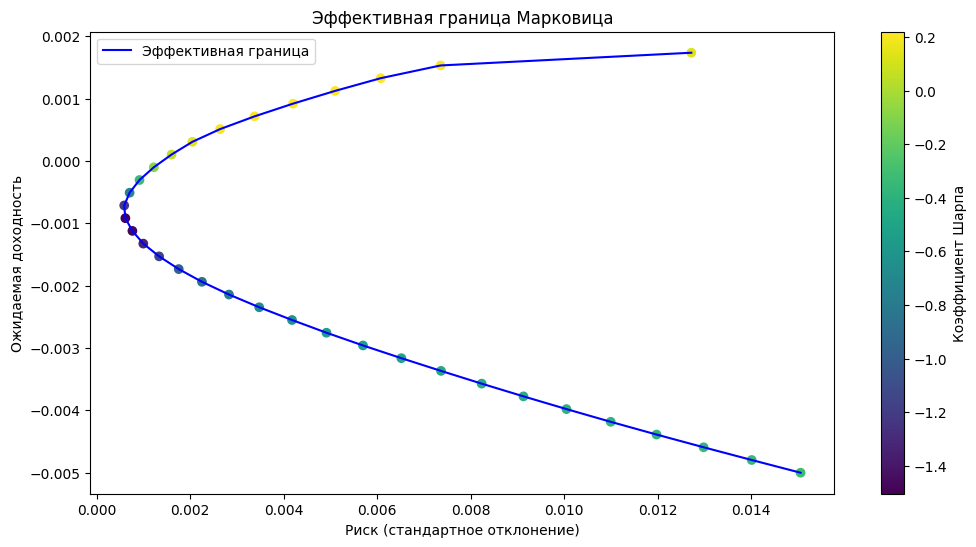


Оптимальный портфель:
Доходность: 0.11%
Риск: 0.51%
Коэффициент Шарпа: 0.22

Веса активов:
AFKS: 0.00%
AFLT: 11.80%
ALRS: 0.00%
BELU: 0.00%
CHMF: 1.17%
FEES: 0.00%
FIXP: 3.58%
FLOT: 0.00%
GAZP: 0.53%
GMKN: 0.00%
HYDR: 0.00%
IRAO: 0.00%
LKOH: 1.75%
MAGN: 0.00%
MGNT: 0.00%
MOEX: 3.66%
MTSS: 0.00%
NVTK: 0.00%
OZON: 6.02%
PLZL: 11.12%
ROSN: 0.88%
RTKM: 0.00%
RUAL: 0.00%
SBER: 0.86%
TATN: 0.00%
TCSG: 1.20%
TRNFP: 0.00%
VTBR: 0.00%
X5: 10.95%
YDEX: 46.47%


In [37]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def calculate_efficient_frontier(expected_returns, cov_matrix, risk_free_rate=0.0, num_points=50):
    """
    Рассчитывает эффективную границу методом Марковица.

    Параметры:
        expected_returns (pd.Series): Ожидаемые доходности активов
        cov_matrix (pd.DataFrame): Ковариационная матрица
        risk_free_rate (float): Безрисковая ставка
        num_points (int): Количество точек на границе

    Возвращает:
        dict: Результаты оптимизации (доходности, риски, веса)
    """
    n_assets = len(expected_returns)

    min_ret = max(expected_returns.min(), -0.005)
    max_ret = max(expected_returns.max(), 0.005)
    target_returns = np.linspace(min_ret, max_ret, num_points)

    results = {
        'returns': [],
        'risks': [],
        'weights': [],
        'sharpe': []
    }

    cov_matrix = self_regularize_covariance(cov_matrix.values)
    cov_matrix = pd.DataFrame(cov_matrix,
                            index=expected_returns.index,
                            columns=expected_returns.index)

    def portfolio_risk(weights):
        port_var = weights @ cov_matrix.values @ weights.T
        return np.sqrt(abs(port_var))

    def portfolio_return(weights):
        return weights @ expected_returns.values

    for target in target_returns:
        constraints = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'eq', 'fun': lambda w: portfolio_return(w) - target}
        ]
        bounds = [(0, 1) for _ in range(n_assets)]

        init_weights = np.random.dirichlet(np.ones(n_assets))

        try:
            opt = minimize(
                fun=portfolio_risk,
                x0=init_weights,
                method='SLSQP',
                bounds=bounds,
                constraints=constraints,
                tol=1e-8,
                options={'maxiter': 1000}
            )

            if opt.success and not np.isnan(opt.fun) and opt.fun > 0:
                results['returns'].append(target)
                results['risks'].append(opt.fun)
                results['weights'].append(opt.x)
                sharpe = (target - risk_free_rate) / opt.fun
                results['sharpe'].append(sharpe)

        except Exception as e:
            continue

    return results

def self_regularize_covariance(matrix, max_attempts=5):
    """Автоматическая регуляризация ковариационной матрицы"""
    for i in range(max_attempts):
        try:
            np.linalg.cholesky(matrix)
            return matrix
        except np.linalg.LinAlgError:
            matrix += np.eye(matrix.shape[0]) * 1e-5 * (i+1)
    return matrix

last_date = results['rolling_year_exp'].index.get_level_values('Date')[-1]

cov_matrix = results['rolling_year_exp'].xs(last_date, level='Date').copy()

expected_returns = (
    returns
    .rolling(window=252, min_periods=10)
    .mean()
    .ffill()
    .bfill()
    .loc[last_date]
)

cov_matrix = cov_matrix.fillna(0).values
expected_returns = expected_returns.fillna(0).values

er_series = pd.Series(expected_returns,
                     index=returns.columns,
                     name='Returns')
cov_df = pd.DataFrame(cov_matrix,
                     columns=returns.columns,
                     index=returns.columns)

print("\nСтатистика перед оптимизацией:")
print(f"Минимальная доходность: {er_series.min():.6f}")
print(f"Максимальная доходность: {er_series.max():.6f}")
print(f"След ковариационной матрицы: {np.trace(cov_df.values):.4f}")

frontier = calculate_efficient_frontier(er_series, cov_df)

if not frontier['returns']:
    print("\nНе удалось построить эффективную границу!")
    print("Возможные причины:")
    print("- Невозможно достичь заданных целевых доходностей")
    print("- Проблемы с численной стабильностью")
    print("- Недостаточное количество активов")
else:
    plt.figure(figsize=(12, 6))
    plt.plot(frontier['risks'], frontier['returns'], 'b-', label='Эффективная граница')
    plt.scatter(frontier['risks'], frontier['returns'], c=frontier['sharpe'], cmap='viridis')
    plt.colorbar(label='Коэффициент Шарпа')
    plt.xlabel('Риск (стандартное отклонение)')
    plt.ylabel('Ожидаемая доходность')
    plt.title('Эффективная граница Марковица')
    plt.legend()
    plt.show()

    try:
        max_sharpe_idx = np.nanargmax(frontier['sharpe'])
        print("\nОптимальный портфель:")
        print(f"Доходность: {frontier['returns'][max_sharpe_idx]*100:.2f}%")
        print(f"Риск: {frontier['risks'][max_sharpe_idx]*100:.2f}%")
        print(f"Коэффициент Шарпа: {frontier['sharpe'][max_sharpe_idx]:.2f}")
        print("\nВеса активов:")
        for ticker, weight in zip(er_series.index, frontier['weights'][max_sharpe_idx]):
            print(f"{ticker}: {weight*100:.2f}%")
    except ValueError:
        print("\nНе удалось найти оптимальный портфель из-за отсутствия данных")

In [5]:
tickers = df['TICKER'].unique()

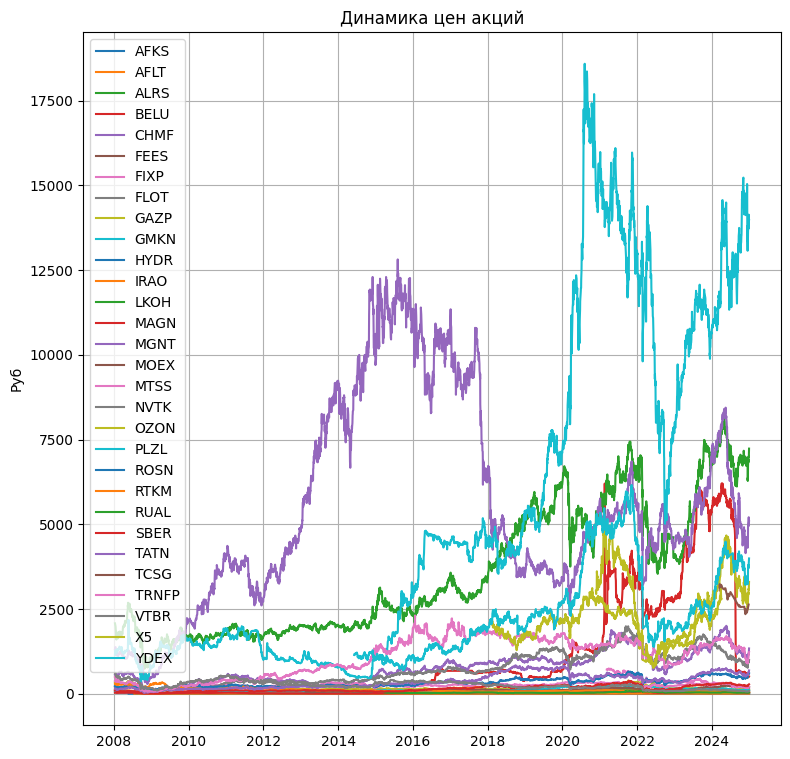

In [7]:
plt.figure(figsize = (9,9))
plt.title('Динамика цен акций')

for ticker in tickers:

    mask = df['TICKER'].eq(ticker)

    plt.plot(df[mask]['DATE'], df[mask]['CLOSE'], label = ticker)

plt.legend()
plt.grid()
plt.ylabel('Руб');

In [8]:
# Выбор исторического окна: 2019-12-31 по 2024-12-31
start_date = '2019-12-31'
end_date = '2024-12-31'
df_window = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]

In [9]:
pivot_data = df_window.pivot(index='DATE', columns='TICKER', values='CLOSE').sort_index(ascending=True)

In [10]:
len(pivot_data)

1250

In [11]:
pivot_data.isna().sum() / len(pivot_data) * 100

,0
TICKER,
AFKS,0.00
AFLT,0.00
ALRS,0.00
BELU,0.48
CHMF,0.00
FEES,1.12
FIXP,23.92
FLOT,15.44
GAZP,0.00


<ipython-input-12-2fddbf7a78c8>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_data.pct_change()


Text(0, 0.5, 'daily returns')

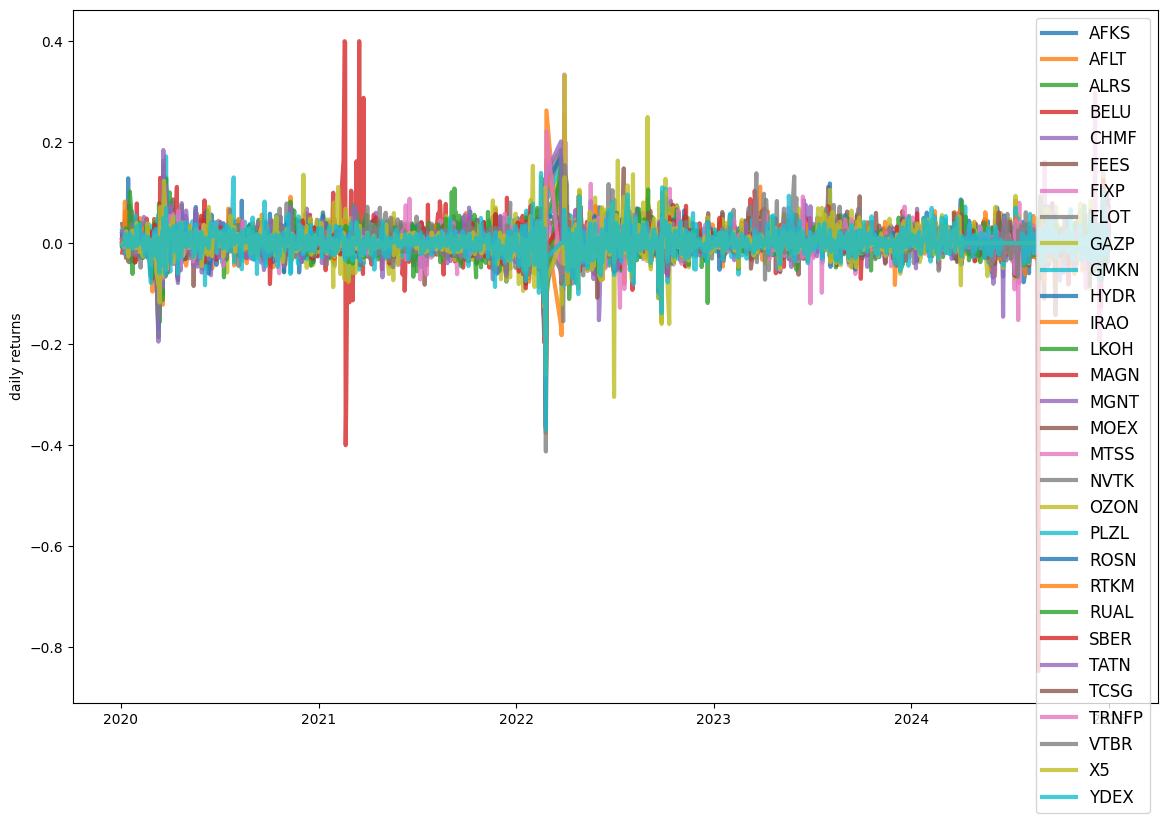

In [12]:
returns = pivot_data.pct_change()

plt.figure(figsize=(14, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

__Граница эффективности портфелей__ - combination of stocks that has the lowest risk for a given expected return

In [13]:
returns = pivot_data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.1

<ipython-input-13-bb297d6e59b4>:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_data.pct_change()


In [14]:
# Выбрать схему взвешивания наблюдений для последующего расчёта границы эффективных портфелей для различных ограничений.

num_intervals = len(returns.index.unique())
lambda_ = 0.97
weights = np.array([lambda_**(num_months - t - 1) for t in range(num_months)])
weights = weights / np.sum(weights)  # Нормировка весов

# Присвоение весов к данным
date_weights = dict(zip(returns.index.unique(), weights))

returns['w'] = returns.index.map(date_weights)

for col in returns.columns[:-1]:
    returns[col] = returns[col] * returns['w']

NameError: name 'num_months' is not defined

In [15]:
from frontier import (portfolio_annualised_performance,
                        neg_sharpe_ratio,
                        max_sharpe_ratio,
                        portfolio_volatility,
                        min_variance,
                        calculated_results,
                        efficient_return
                    )

/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:438: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:492: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


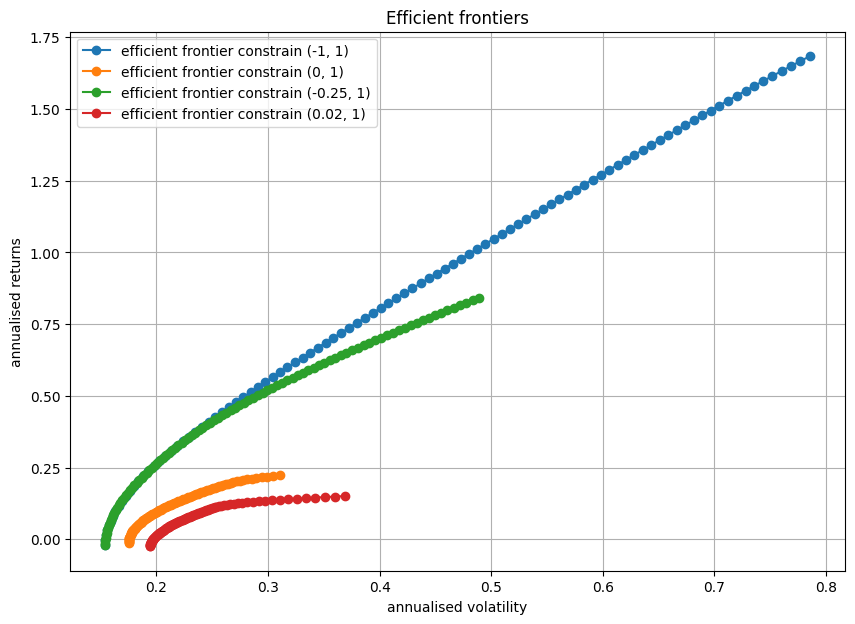

In [16]:
plt.figure(figsize=(10, 7))
plt.title(f'Efficient frontiers')

# короткие продажи разрешены без ограничений
constarin_set = (-1,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# короткие продажи запрещены
constarin_set = (0,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')

# доходы от короткой продажи каждой акции не должны превышать 25% от собственных средств (капитала) инвестора
constarin_set = (-0.25,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


# 0.02% капитала должно быть вложено в каждую акцию
constarin_set = (0.02,1)
maxSR_std, maxSR_returns, maxSR_allocation, minVol_std, minVol_returns, minVol_allocation, efficient_list, target_returns = calculated_results(mean_returns,
                                                                                                                                               cov_matrix,
                                                                                                                                               risk_free_rate,
                                                                                                                                               pivot_data,
                                                                                                                                              constarin_set)
plt.plot(efficient_list,target_returns, label = f'efficient frontier constrain {constarin_set}', marker = 'o')


plt.xlabel('annualised volatility')
plt.ylabel('annualised returns')
plt.legend()
plt.grid()